<a href="https://colab.research.google.com/github/TBeatrix/Deep_learning_nagyhazi/blob/main/milestone2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning II. Milestone**



---



---



**Team name: Pain & Panic**

team members: T63K63 - Tugyi Beatrix,
              IT9P0Z - Heizer Levente

In [ ]:
import torch
!pip install torch_geometric

from torch import nn
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling

!pip install nodevectors

!pip install gensim

import re
import networkx as nx
from nodevectors import Node2Vec
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
import time
import warnings
warnings.simplefilter("ignore", category=UserWarning)
import gensim
warnings.simplefilter("default", category=UserWarning)

!pip install gensim==3.6

import csrgraph as cg
from nodevectors.embedders import BaseNodeEmbedder


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for nodevectors: filename=nodevectors-0.1.23-py3-none-any.whl size=17930 sha256=71b6c042ed21151223114a04d0028dc9b8fed093b55929751f294bf430fef136
  Stored in directory: /root/.cache/pip/wheels/b5/4c/91/bf05a408dda66b136034cf5c91e4a40381fc01aa0f5ecd8f89
  Created wheel for csrgraph: filename=csrgraph-0.1.28-py3-none-any.whl size=17615 sha256=6011106ee66103f783d1bc1327db35893543aee505aa4f405930f57e75594e0c
  Stored in directory: /root/.cache/pip/wheels/0f/b5/63/fd61f029bb51e69d1d3ab578bc3361159f52bd99e46bd8d5c3
Successfully built nodevectors csrgraph
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 62.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gensim: filename=gensim-3.6.0-cp310-cp310-linux_x86_64.whl size=23778010 sha256=b42fe994d7e50201487f76ab99690106938cbabce9bf726

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
nx.adj_matrix = nx.adjacency_matrix

In [ ]:
# Node2Vec
class Node2Vec(BaseNodeEmbedder):
    def __init__(
        self,
        n_components=32,
        walklen=30,
        epochs=20,
        return_weight=1.,
        neighbor_weight=1.,
        threads=0,
        keep_walks=False,
        verbose=True,
        w2vparams={"window":10, "negative":5, "iter":10,
                   "batch_words":128}):

        if type(threads) is not int:
            raise ValueError("Threads argument must be an int!")
        if walklen < 1 or epochs < 1:
            raise ValueError("Walklen and epochs arguments must be > 1")
        self.n_components = n_components
        self.walklen = walklen
        self.epochs = epochs
        self.keep_walks = keep_walks
        if 'size' in w2vparams.keys():
            raise AttributeError("Embedding dimensions should not be set "
                + "through w2v parameters, but through n_components")
        self.w2vparams = w2vparams
        self.return_weight = return_weight
        self.neighbor_weight = neighbor_weight
        if threads == 0:
            threads = numba.config.NUMBA_DEFAULT_NUM_THREADS
        self.threads = threads
        w2vparams['workers'] = threads
        self.verbose = verbose

    def fit(self, G):
        """
        NOTE: Currently only support str or int as node name for graph
        Parameters
        ----------
        G : graph data
            Graph to embed
            Can be any graph type that's supported by csrgraph library
            (NetworkX, numpy 2d array, scipy CSR matrix, CSR matrix components)
        """
        if not isinstance(G, cg.csrgraph):
            G = cg.csrgraph(G, threads=self.threads)
        if G.threads != self.threads:
            G.set_threads(self.threads)
        # Because networkx graphs are actually iterables of their nodes
        #   we do list(G) to avoid networkx 1.X vs 2.X errors
        node_names = G.names
        if type(node_names[0]) not in [int, str, np.int32, np.uint32,
                                       np.int64, np.uint64]:
            raise ValueError("Graph node names must be int or str!")
        # Adjacency matrix
        walks_t = time.time()
        if self.verbose:
            print("Making walks...", end=" ")
        self.walks = G.random_walks(walklen=self.walklen,
                                    epochs=self.epochs,
                                    return_weight=self.return_weight,
                                    neighbor_weight=self.neighbor_weight)
        if self.verbose:
            print(f"Done, T={time.time() - walks_t:.2f}")
            print("Mapping Walk Names...", end=" ")
        map_t = time.time()
        self.walks = pd.DataFrame(self.walks)
        # Map nodeId -> node name
        node_dict = dict(zip(np.arange(len(node_names)), node_names))
        for col in self.walks.columns:
            self.walks[col] = self.walks[col].map(node_dict).astype(str)
        # Somehow gensim only trains on this list iterator
        # it silently mistrains on array input
        self.walks = [list(x) for x in self.walks.itertuples(False, None)]
        if self.verbose:
            print(f"Done, T={time.time() - map_t:.2f}")
            print("Training W2V...", end=" ")
            if gensim.models.word2vec.FAST_VERSION < 1:
                print("WARNING: gensim word2vec version is unoptimized"
                    "Try version 3.6 if on windows, versions 3.7 "
                    "and 3.8 have had issues")
        w2v_t = time.time()
        # Train gensim word2vec model on random walks
        self.model = gensim.models.Word2Vec(
            sentences=self.walks,
            vector_size=self.n_components, #!!!!
            **self.w2vparams)
        if not self.keep_walks:
            del self.walks
        if self.verbose:
            print(f"Done, T={time.time() - w2v_t:.2f}")

    def fit_transform(self, G):
        """
        NOTE: Currently only support str or int as node name for graph
        Parameters
        ----------
        G : graph data
            Graph to embed
            Can be any graph type that's supported by csrgraph library
            (NetworkX, numpy 2d array, scipy CSR matrix, CSR matrix components)
        """
        if not isinstance(G, cg.csrgraph):
            G = cg.csrgraph(G, threads=self.threads)
        self.fit(G)
        w = np.array(
            pd.DataFrame.from_records(
            pd.Series(np.arange(len(G.nodes())))
              .apply(self.predict)
              .values)
        )
        return w

    def predict(self, node_name):
        """
        Return vector associated with node
        node_name : str or int
            either the node ID or node name depending on graph format
        """
        # current hack to work around word2vec problem
        # ints need to be str -_-
        if type(node_name) is not str:
            node_name = str(node_name)
        return self.model.wv.__getitem__(node_name)

    def save_vectors(self, out_file):
        """
        Save as embeddings in gensim.models.KeyedVectors format
        """
        self.model.wv.save_word2vec_format(out_file)

    def load_vectors(self, out_file):
        """
        Load embeddings from gensim.models.KeyedVectors format
        """
        self.model = gensim.wv.load_word2vec_format(out_file)

In [ ]:
def get_ego_indexes(files):
  pattern = re.compile(r'\d+')
  ego_indexes = [int(pattern.search(s).group()) for s in files if pattern.search(s)]
  ego_indexes = sorted(set(ego_indexes))
  return ego_indexes

In [ ]:
class GraphData:
  edge_index = []
  edge_list = []
  nodes = []
  X = []
  circles = []
  X_names = []
  embeddings = []

  def __init__(self, edges, edge_list, X, circles, X_names, embeddings, nodes):
    self.edge_index = torch.tensor(edges)
    self.edge_list = edge_list
    self.X = X.float()
    self.circles = circles
    self.X_names = X_names
    self.embeddings = torch.tensor(embeddings)
    self.nodes = nodes

In [ ]:
def visualize(g, title="Graph", edge='blue'):
    pos = nx.kamada_kawai_layout(g)
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.axis('on')
    nx.draw_networkx(g, pos=pos, node_size=10,
                     arrows=False, width=1, style='solid', with_labels= False)
    plt.show()

#Facebook

###Data acquisition

In [ ]:
!wget https://snap.stanford.edu/data/facebook.tar.gz

--2023-11-19 08:23:46--  https://snap.stanford.edu/data/facebook.tar.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 732104 (715K) [application/x-gzip]
Saving to: ‘facebook.tar.gz’

facebook.tar.gz     100%[===================>] 714.95K  1.17MB/s    in 0.6s    

2023-11-19 08:23:47 (1.17 MB/s) - ‘facebook.tar.gz’ saved [732104/732104]



In [ ]:
files = ! tar xvzf facebook.tar.gz

In [ ]:
Fb_ego_indexes = get_ego_indexes(files)

# Convert data to graph and create embeddings with Node2Vec

In [ ]:
Facebook_graphs = []
for index in range(len(Fb_ego_indexes)-1):
  f = open(f'facebook/{Fb_ego_indexes[index]}.edges', "rt")
  edges_str = f.readlines()
  edges = [list(map(int, item.strip().split())) for item in edges_str]
  # Transpose the data to get desired format
  edges = [list(row) for row in zip(*edges)]

  edge_list =   [(int(x.split()[0]), int(x.split()[1])) for x in edges_str]
  f = open(f'facebook/{Fb_ego_indexes[index]}.circles', "rt")
  circles_str = f.readlines()
  circles = [list(map(int, item.split('\t')[1:])) for item in circles_str]

  f = open(f'facebook/{Fb_ego_indexes[index]}.featnames', "rt")
  feat_name_str = f.readlines()
  X_names = [item.split(';anonymized feature')[0].split(';') for item in feat_name_str]

  f = open(f'facebook/{Fb_ego_indexes[index]}.egofeat', "rt")
  feat_str = f.readlines()
  X = []
  X.append(list(map(int, feat_str[0].split()[1:])) )
  X = torch.tensor(X)

  f = open(f'facebook/{Fb_ego_indexes[index]}.feat', "rt")
  feat_str = f.readlines()
  X_ego = torch.tensor([list(map(int, item.split()[1:]))[0:-1] for item in feat_str])
  X = torch.cat([ X, X_ego], dim=0)


  # Node2Vec expects an NX graph
  G  = nx.from_edgelist(edge_list)
  # Adding extra nodes to represent the isolated nodes
  max = torch.tensor(edges)[0, :].max()
  for node_id in range(max):
    if node_id not in G:
        G.add_node(node_id)
  # Node2Vec model specification
  n2v = Node2Vec(n_components=64, walklen=10, epochs=50, return_weight=1.0, neighbor_weight=1.0, threads=0, w2vparams={'window': 4, 'negative': 5, 'epochs':10, 'ns_exponent': 0.5, 'batch_words': 128})
  # Fit and get the embedding
  n2v.fit(G)
  nodes = G.nodes()
  embeddings = []
  for node in nodes:
    embeddings.append(n2v.predict(node))

  Facebook_graphs.append(GraphData(edges, edge_list, X, circles, X_names, embeddings, nodes))

Making walks... Done, T=0.03
Mapping Walk Names... Done, T=0.58
Training W2V... WARNING: gensim word2vec version is unoptimizedTry version 3.6 if on windows, versions 3.7 and 3.8 have had issues
Done, T=3.12
Making walks... Done, T=0.08
Mapping Walk Names... Done, T=0.86
Training W2V... WARNING: gensim word2vec version is unoptimizedTry version 3.6 if on windows, versions 3.7 and 3.8 have had issues
Done, T=19.72
Making walks... Done, T=0.01
Mapping Walk Names... Done, T=0.19
Training W2V... WARNING: gensim word2vec version is unoptimizedTry version 3.6 if on windows, versions 3.7 and 3.8 have had issues
Done, T=7.17
Making walks... Done, T=0.01
Mapping Walk Names... Done, T=0.21
Training W2V... WARNING: gensim word2vec version is unoptimizedTry version 3.6 if on windows, versions 3.7 and 3.8 have had issues
Done, T=6.13
Making walks... Done, T=0.01
Mapping Walk Names... Done, T=0.51
Training W2V... WARNING: gensim word2vec version is unoptimizedTry version 3.6 if on windows, versions 

https://github.com/pyg-team/pytorch_geometric/issues/3668


I think this is totally correct. It seems like you are looking at the shapes of edge_index, while you may want to look at the shapes of edge_label and edge_label_index (which correctly model a 80/10/10 split ratio). Here, edge_index is solely used for message passing, i.e.,
for training, we exchange messages on all training edges
for validation, we exchange messages on all training edges
for testing, we exchange messages on all training and validation edges

### Test data loading

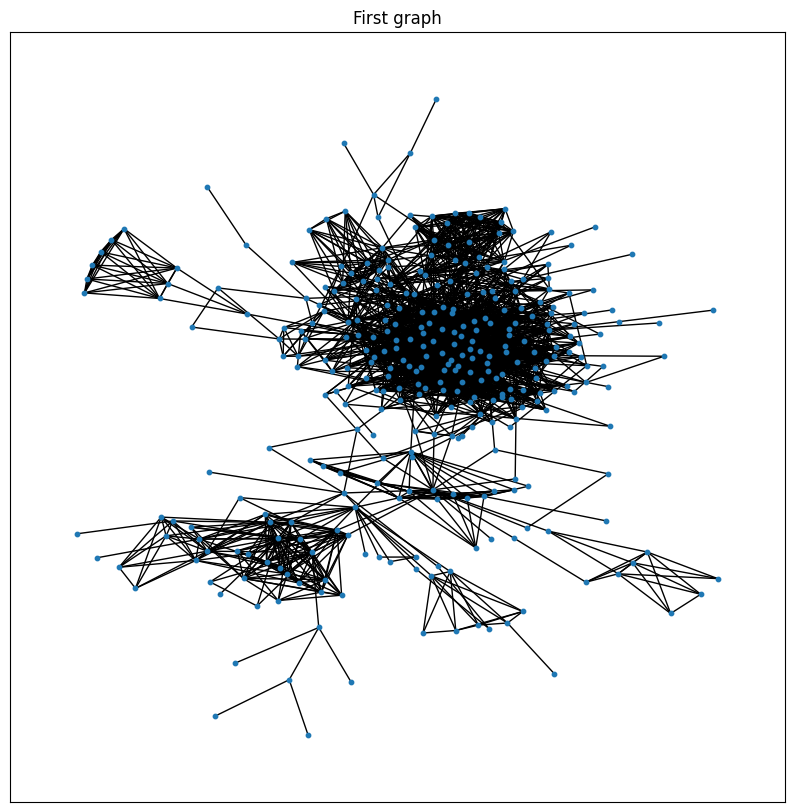

In [ ]:
Edge_graph = nx.from_edgelist(Facebook_graphs[0].edge_list)
visualize( Edge_graph, "First graph")

In [ ]:
Facebook_graphs[0].X[0]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0])

In [ ]:
Facebook_graphs[0].edge_index

tensor([[236, 122,  24,  ...,  85,  98, 291],
        [186, 285, 346,  ...,  75, 332, 339]])

In [ ]:
Facebook_graphs[0].embeddings

tensor([[ 7.4535e-01,  2.7067e-01, -1.2935e+00,  ..., -9.9964e-01,
         -6.0000e-01, -5.4737e-01],
        [ 9.4587e-01, -1.8194e-02,  2.1169e-01,  ..., -3.5463e-01,
          7.0618e-01, -1.3428e-01],
        [ 6.1775e-01,  5.7734e-01, -1.2911e-03,  ..., -4.0401e-01,
         -1.2300e-01, -3.3883e-01],
        ...,
        [ 1.1792e+00,  2.0294e-01,  2.7220e-01,  ..., -6.9480e-02,
         -2.4514e-01,  5.6108e-01],
        [-5.7642e-01, -2.0988e+00, -4.9122e-02,  ...,  9.9294e-01,
         -8.1592e-01, -2.1707e-01],
        [ 8.1149e-01, -3.0691e-01, -6.3642e-01,  ...,  2.7305e-01,
          8.0242e-01, -8.9082e-03]])

In [ ]:
Facebook_graphs[0].nodes

NodeView((236, 186, 122, 285, 24, 346, 271, 304, 176, 9, 130, 329, 204, 213, 252, 332, 82, 65, 276, 26, 280, 272, 211, 199, 84, 133, 62, 239, 172, 322, 53, 3, 170, 175, 46, 56, 254, 194, 231, 117, 127, 135, 103, 188, 23, 116, 73, 299, 288, 315, 119, 323, 48, 57, 200, 98, 313, 63, 344, 67, 118, 325, 277, 134, 270, 76, 36, 223, 274, 88, 21, 339, 108, 197, 169, 275, 273, 83, 28, 312, 242, 214, 20, 307, 71, 333, 207, 168, 308, 341, 128, 334, 238, 265, 141, 78, 345, 317, 158, 38, 302, 27, 54, 139, 109, 291, 142, 203, 105, 232, 64, 217, 248, 126, 224, 261, 283, 144, 226, 290, 25, 342, 146, 300, 94, 1, 184, 159, 149, 13, 59, 17, 326, 80, 187, 161, 66, 31, 136, 7, 255, 49, 320, 85, 246, 123, 284, 140, 137, 343, 115, 297, 185, 104, 324, 171, 111, 14, 310, 32, 30, 222, 92, 72, 40, 125, 266, 212, 278, 340, 237, 311, 309, 330, 230, 70, 16, 249, 39, 251, 10, 55, 228, 69, 113, 258, 257, 196, 156, 303, 286, 81, 174, 293, 33, 42, 347, 2, 281, 263, 279, 51, 338, 162, 19, 75, 218, 268, 314, 5, 178, 192,

In [ ]:
Facebook_graphs[0].X_names

[['0 birthday'],
 ['1 birthday'],
 ['2 birthday'],
 ['3 birthday'],
 ['4 birthday'],
 ['5 birthday'],
 ['6 birthday'],
 ['7 birthday'],
 ['8 education', 'classes', 'id'],
 ['9 education', 'classes', 'id'],
 ['10 education', 'classes', 'id'],
 ['11 education', 'classes', 'id'],
 ['12 education', 'classes', 'id'],
 ['13 education', 'concentration', 'id'],
 ['14 education', 'concentration', 'id'],
 ['15 education', 'concentration', 'id'],
 ['16 education', 'concentration', 'id'],
 ['17 education', 'concentration', 'id'],
 ['18 education', 'concentration', 'id'],
 ['19 education', 'concentration', 'id'],
 ['20 education', 'degree', 'id'],
 ['21 education', 'degree', 'id'],
 ['22 education', 'degree', 'id'],
 ['23 education', 'degree', 'id'],
 ['24 education', 'school', 'id'],
 ['25 education', 'school', 'id'],
 ['26 education', 'school', 'id'],
 ['27 education', 'school', 'id'],
 ['28 education', 'school', 'id'],
 ['29 education', 'school', 'id'],
 ['30 education', 'school', 'id'],
 ['31 e

###Data Splitting

In [ ]:
# TODO: ezt importálással megoldani
from typing import Union, Tuple
import copy
from torch import Tensor
from torch_geometric.utils import add_self_loops, negative_sampling
from torch_geometric.transforms import BaseTransform


class RandomLinkSplit(BaseTransform):
    def __init__(
        self,
        num_val: Union[int, float] = 0.1,
        num_test: Union[int, float] = 0.2,
        is_undirected: bool = False,
        key: str = 'edge_label',
        split_labels: bool = False,
        add_negative_train_samples: bool = True,
        neg_sampling_ratio: float = 1.0,
    ):
        self.num_val = num_val
        self.num_test = num_test
        self.is_undirected = is_undirected
        self.key = key
        self.split_labels = split_labels
        self.add_negative_train_samples = add_negative_train_samples
        self.neg_sampling_ratio = neg_sampling_ratio

    def __call__(self, data: Data) -> Tuple[Data, Data, Data]:
        perm = torch.randperm(data.num_edges, device=data.edge_index.device)
        if self.is_undirected:
            perm = perm[data.edge_index[0] <= data.edge_index[1]]

        num_val, num_test = self.num_val, self.num_test
        if isinstance(num_val, float):
            num_val = int(num_val * perm.numel())
        if isinstance(num_test, float):
            num_test = int(num_test * perm.numel())

        num_train = perm.numel() - num_val - num_test
        if num_train <= 0:
            raise ValueError("Insufficient number of edges for training.")

        train_edges = perm[:num_train]
        val_edges = perm[num_train:num_train + num_val]
        test_edges = perm[num_train + num_val:]
        train_val_edges = perm[:num_train + num_val]

        # Create data splits:
        train_data = self._split_data(data, train_edges)
        val_data = self._split_data(data, train_edges)
        test_data = self._split_data(data, train_val_edges)

        # Create negative samples:
        num_neg_train = 0
        if self.add_negative_train_samples:
            num_neg_train = int(num_train * self.neg_sampling_ratio)
        num_neg_val = int(num_val * self.neg_sampling_ratio)
        num_neg_test = int(num_test * self.neg_sampling_ratio)

        num_neg = num_neg_train + num_neg_val + num_neg_test
        neg_edge_index = negative_sampling(
            add_self_loops(data.edge_index)[0], num_nodes=data.num_nodes,
            num_neg_samples=num_neg, method='sparse')

        # Create labels:
        self._create_label(
            data,
            train_edges,
            neg_edge_index[:, num_neg_val + num_neg_test:],
            out=train_data,
        )
        self._create_label(
            data,
            val_edges,
            neg_edge_index[:, :num_neg_val],
            out=val_data,
        )
        self._create_label(
            data,
            test_edges,
            neg_edge_index[:, num_neg_val:num_neg_val + num_neg_test],
            out=test_data,
        )

        return train_data, val_data, test_data

    def _split(self, edge_index: Tensor, index: Tensor) -> Tensor:
        edge_index = edge_index[:, index]

        if self.is_undirected:
            edge_index = torch.cat([edge_index, edge_index.flip([0])], dim=-1)

        return edge_index

    def _split_data(self, data: Data, index: Tensor) -> Data:
        num_edges = data.num_edges

        data = copy.copy(data)
        data.edge_index = self._split(data.edge_index, index)

        for key, value in data.items():
            if isinstance(value, Tensor) and value.size(0) == num_edges:
                value = value[index]
                if self.is_undirected:
                    value = torch.cat([value, value], dim=0)
                data[key] = value

        return data

    def _create_label(self, data: Data, index: Tensor, neg_edge_index: Tensor,
                      out: Data):

        edge_index = data.edge_index[:, index]

        if hasattr(data, self.key):
            edge_label = data[self.key]
            assert edge_label.dtype == torch.long and edge_label.dim() == 1
            edge_label = edge_label[index].add_(1)
            delattr(data, self.key)
        else:
            edge_label = torch.ones(index.numel(), device=index.device)

        if neg_edge_index.numel() > 0:
            neg_edge_label = edge_label.new_zeros(neg_edge_index.size(1))

        if self.split_labels:
            out[f'pos_{self.key}'] = edge_label
            out[f'pos_{self.key}_index'] = edge_index
            if neg_edge_index.numel() > 0:
                out[f'neg_{self.key}'] = neg_edge_label
                out[f'neg_{self.key}_index'] = neg_edge_index

        else:
            if neg_edge_index.numel() > 0:
                edge_label = torch.cat([edge_label, neg_edge_label], dim=0)
                edge_index = torch.cat([edge_index, neg_edge_index], dim=-1)
            out[self.key] = edge_label
            out[f'{self.key}_index'] = edge_index

        return out

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}(num_val={self.num_val}, '
                f'num_test={self.num_test})')

In [ ]:
def split_data(graph, use_embeddings = True):
  split = RandomLinkSplit(
      num_val=0.05,
      num_test=0.1,
      is_undirected=True,
      add_negative_train_samples=False,
      neg_sampling_ratio=1.0,
  )
  if use_embeddings:
     data = Data(x=graph.embeddings, edge_index=graph.edge_index)
  else:
     data = Data(x=graph.X, edge_index=graph.edge_index)
  train_data, val_data, test_data = split(data)

  print('train_data:', train_data)
  print('val_data:', val_data)
  print('test_data:', test_data)
  return train_data, val_data, test_data

#GNN_VAE

### Training function

In [ ]:

class GNNVAE(nn.Module):
  def __init__(self, in_channels, hidden_channels, out_channels):
    super(GNNVAE,self).__init__()
    self.GNNConvIn = GCNConv(in_channels=in_channels, out_channels=hidden_channels)
    self.GNNConvHidden = GCNConv(in_channels=hidden_channels, out_channels=hidden_channels)
    self.GNNConvOut = GCNConv(in_channels=hidden_channels, out_channels=out_channels)

  def encode(self,x,edge_index):
    x = self.GNNConvIn(x,edge_index).relu()

    x = self.GNNConvOut(x,edge_index).relu()
    return x

  def decode(self,z,edges):
    return (z[edges[0]] * z[edges[1]]).sum(dim=-1)

  def train_GNNVAE(self, train_dataset,val_dataset,optimizer,epoch,verbose=False):
    for epoch in range(0,epoch):
      self.train()
      optimizer.zero_grad()
      x, edge_index, edge_label_index = train_dataset.x.to(device), train_dataset.edge_index.to(device), train_dataset.edge_label_index.to(device)
      z = self.encode(x,edge_index)

      neg_edge_index = negative_sampling(
              edge_index=edge_index, num_nodes=torch.tensor(train_dataset.num_nodes).to(device),
              num_neg_samples=len(edge_label_index[1]), method='sparse')

      pos_neg_edge_index = torch.cat(
          [edge_label_index, neg_edge_index],
          dim=-1,
      )

      edge_y = torch.cat([
          torch.ones(neg_edge_index.size(1)).to(device),
          train_dataset.edge_label.new_zeros(neg_edge_index.size(1)).to(device)
      ], dim=0)

      out = self.decode(z,pos_neg_edge_index)

      loss_fn = torch.nn.BCEWithLogitsLoss()
      loss = loss_fn(out,edge_y)
      loss.backward()
      optimizer.step()

      # validation step
      if (verbose and epoch % 10 == 0):
        val_roc_auc = self.eval_GNNVAE(val_dataset)
        print(f"Train loss: {loss}\nValidation AUC: {val_roc_auc}")
    return self

  @torch.no_grad()
  def eval_GNNVAE(self, data):
    self.eval()
    x, edge_index, edge_label_index = data.x.to(device), data.edge_index.to(device), data.edge_label_index.to(device)
    z = self.encode(x, edge_index)
    out = self.decode(z, edge_label_index).view(-1).sigmoid()

    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())



## Training

In [ ]:
test_aucs = []
for i in range(len(Facebook_graphs)):
  graph = Facebook_graphs[i]
  train_data, val_data, test_data = split_data(graph, True)
  model = GNNVAE(train_data.x.shape[1], 32, 16).to(device)
  optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

  model = model.train_GNNVAE(train_data, val_data, optimizer,300)
  test_auc = model.eval_GNNVAE(test_data)
  test_aucs.append(test_auc)

  print(f"Test: {test_auc:.3f}")
print(f"Average Test AUC: {np.array(test_aucs).sum() / len(test_aucs)}")

train_data: Data(x=[348, 64], edge_index=[2, 4286], edge_label=[2143], edge_label_index=[2, 2143])
val_data: Data(x=[348, 64], edge_index=[2, 4286], edge_label=[250], edge_label_index=[2, 250])
test_data: Data(x=[348, 64], edge_index=[2, 4536], edge_label=[502], edge_label_index=[2, 502])
Test: 0.926
train_data: Data(x=[1912, 64], edge_index=[2, 45476], edge_label=[22738], edge_label_index=[2, 22738])
val_data: Data(x=[1912, 64], edge_index=[2, 45476], edge_label=[2674], edge_label_index=[2, 2674])
test_data: Data(x=[1912, 64], edge_index=[2, 48150], edge_label=[5348], edge_label_index=[2, 5348])
Test: 0.949
train_data: Data(x=[573, 64], edge_index=[2, 5428], edge_label=[2714], edge_label_index=[2, 2714])
val_data: Data(x=[573, 64], edge_index=[2, 5428], edge_label=[318], edge_label_index=[2, 318])
test_data: Data(x=[573, 64], edge_index=[2, 5746], edge_label=[638], edge_label_index=[2, 638])
Test: 0.972
train_data: Data(x=[686, 64], edge_index=[2, 2880], edge_label=[1440], edge_label_